<h1>Import modules</h1>

In [2]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import HashingEncoder, OneHotEncoder

<h1>Review data</h1>

In [5]:
data = pd.read_csv('zillow_df.csv')
data.head()

,pop_rank,city,state,month,year,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus
0,83,"Akron, OH",OH,2,2008,111182.75,398.0,124307.869610,NaN,-13125.119610
1,83,"Akron, OH",OH,3,2008,117496.40,403.0,124112.725495,NaN,-6616.325495
2,83,"Akron, OH",OH,4,2008,116325.50,480.0,124067.896104,NaN,-7742.396104
3,83,"Akron, OH",OH,5,2008,140846.00,478.0,124246.821831,NaN,16599.178169
4,83,"Akron, OH",OH,6,2008,137244.50,603.0,124224.500972,NaN,13019.999028


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27906 entries, 0 to 27905
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pop_rank           27906 non-null  int64  
 1   city               27906 non-null  object 
 2   state              27906 non-null  object 
 3   month              27906 non-null  int64  
 4   year               27906 non-null  int64  
 5   mean_sales_price   27906 non-null  float64
 6   number_of_sales    18325 non-null  float64
 7   home_value         27906 non-null  float64
 8   market_heat_index  11881 non-null  float64
 9   value_surplus      27906 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 2.1+ MB


In [7]:
data.shape

(27906, 10)

In [8]:
data.describe()

,pop_rank,month,year,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus
count,27906.000000,27906.000000,27906.000000,2.790600e+04,18325.000000,2.790600e+04,11881.000000,27906.000000
mean,75.582885,6.495843,2016.182040,2.945135e+05,2512.242674,2.494363e+05,63.527649,45077.241682
std,48.127725,3.451915,4.899423,2.025078e+05,2670.134071,1.631568e+05,19.655255,58227.683253
min,1.000000,1.000000,2008.000000,6.768200e+04,72.000000,4.453395e+04,10.000000,-133828.189372
25%,36.000000,3.000000,2012.000000,1.714907e+05,839.000000,1.468863e+05,50.000000,14565.486548
50%,71.000000,6.000000,2016.000000,2.321299e+05,1474.000000,2.003785e+05,61.000000,31432.623504
75%,109.000000,9.000000,2020.000000,3.371997e+05,3100.000000,2.891278e+05,74.000000,55355.612159
max,242.000000,12.000000,2025.000000,2.100472e+06,23983.000000,1.744104e+06,235.000000,898207.580750


<h1>Handle missing values</h1>

In [10]:
data.isna().sum()

pop_rank                 0
city                     0
state                    0
month                    0
year                     0
mean_sales_price         0
number_of_sales       9581
home_value               0
market_heat_index    16025
value_surplus            0
dtype: int64

In [11]:
#fill number_of_sales and market_heat_index with median
data['number_of_sales'] = data['number_of_sales'].fillna(data.groupby('state')['number_of_sales'].transform('median'))
data['market_heat_index'] = data['market_heat_index'].fillna(data.groupby('state')['market_heat_index'].transform('median'))
data.isna().sum()

pop_rank               0
city                   0
state                  0
month                  0
year                   0
mean_sales_price       0
number_of_sales      781
home_value             0
market_heat_index      0
value_surplus          0
dtype: int64

In [12]:
#check where missing number_of_sales values are still occurring
data.groupby('state')['number_of_sales'].apply(lambda x: x.isna().sum())

state
AL      0
AR      0
AZ      0
CA      0
CO      0
CT      0
DE    198
FL      0
GA      0
HI      0
IA      0
ID      0
IL      0
IN      0
KS      0
KY      0
LA      0
MA      0
MD      0
ME    204
MI      0
MN      0
MO      0
MS    379
NC      0
NE      0
NM      0
NV      0
NY      0
OH      0
OK      0
OR      0
PA      0
RI      0
SC      0
TN      0
TX      0
UT      0
VA      0
WA      0
WI      0
Name: number_of_sales, dtype: int64

In [13]:
data.groupby('state')['number_of_sales'].apply(lambda x: x.notnull().sum())

state
AL     685
AR     408
AZ     408
CA    2856
CO     816
CT     612
DE       0
FL    2502
GA     811
HI     204
IA     204
ID     204
IL     612
IN     612
KS     204
KY     408
LA     365
MA     810
MD     367
ME       0
MI     816
MN     204
MO     612
MS       0
NC    1224
NE     204
NM     204
NV     408
NY    1020
OH    1428
OK     408
OR     204
PA    1632
RI     204
SC     816
TN    1015
TX    1802
UT     408
VA     612
WA     408
WI     408
Name: number_of_sales, dtype: int64

In [14]:
#since DE, ME, and MS have no sales value, we'll use knn_imputer() to fill these values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=12)
data['number_of_sales'] = imputer.fit_transform(data[['number_of_sales']])

In [15]:
data.isna().sum()

pop_rank             0
city                 0
state                0
month                0
year                 0
mean_sales_price     0
number_of_sales      0
home_value           0
market_heat_index    0
value_surplus        0
dtype: int64

In [16]:
#check to see how data was affected
data.describe()

,pop_rank,month,year,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus
count,27906.000000,27906.000000,27906.000000,2.790600e+04,27906.000000,2.790600e+04,27906.000000,27906.000000
mean,75.582885,6.495843,2016.182040,2.945135e+05,2608.806175,2.494363e+05,62.430015,45077.241682
std,48.127725,3.451915,4.899423,2.025078e+05,2501.066151,1.631568e+05,14.483182,58227.683253
min,1.000000,1.000000,2008.000000,6.768200e+04,72.000000,4.453395e+04,10.000000,-133828.189372
25%,36.000000,3.000000,2012.000000,1.714907e+05,1021.000000,1.468863e+05,54.000000,14565.486548
50%,71.000000,6.000000,2016.000000,2.321299e+05,1770.500000,2.003785e+05,62.000000,31432.623504
75%,109.000000,9.000000,2020.000000,3.371997e+05,2794.500000,2.891278e+05,68.000000,55355.612159
max,242.000000,12.000000,2025.000000,2.100472e+06,23983.000000,1.744104e+06,235.000000,898207.580750


This increased the mean and IQR of the number_of_sales but brought them closer to the median

Change month/year to datetime

In [19]:
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1), errors='coerce')
data.head()

,pop_rank,city,state,month,year,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,date
0,83,"Akron, OH",OH,2,2008,111182.75,398.0,124307.869610,61.0,-13125.119610,2008-02-01
1,83,"Akron, OH",OH,3,2008,117496.40,403.0,124112.725495,61.0,-6616.325495,2008-03-01
2,83,"Akron, OH",OH,4,2008,116325.50,480.0,124067.896104,61.0,-7742.396104,2008-04-01
3,83,"Akron, OH",OH,5,2008,140846.00,478.0,124246.821831,61.0,16599.178169,2008-05-01
4,83,"Akron, OH",OH,6,2008,137244.50,603.0,124224.500972,61.0,13019.999028,2008-06-01


In [20]:
#drop month/year columns
data = data.drop(columns=['month', 'year'])
data.head()

,pop_rank,city,state,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,date
0,83,"Akron, OH",OH,111182.75,398.0,124307.869610,61.0,-13125.119610,2008-02-01
1,83,"Akron, OH",OH,117496.40,403.0,124112.725495,61.0,-6616.325495,2008-03-01
2,83,"Akron, OH",OH,116325.50,480.0,124067.896104,61.0,-7742.396104,2008-04-01
3,83,"Akron, OH",OH,140846.00,478.0,124246.821831,61.0,16599.178169,2008-05-01
4,83,"Akron, OH",OH,137244.50,603.0,124224.500972,61.0,13019.999028,2008-06-01


In [21]:
#confirm no missing values
data.isna().sum()

pop_rank             0
city                 0
state                0
mean_sales_price     0
number_of_sales      0
home_value           0
market_heat_index    0
value_surplus        0
date                 0
dtype: int64

<h1>Encode categorical data</h1>

In [23]:
#Use hash encoding for city data
#check number of unique values in city column to determine components
data['city'].nunique()

140

In [24]:
encoder = HashingEncoder(n_components=7)
city_transform = encoder.fit_transform(data['city'])
city_transform.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [25]:
data['state'].nunique()

41

In [26]:
#set up same encoder for state data with 2 components to keep similar ratio
encoder2 = HashingEncoder(n_components=2)
state_transform = encoder2.fit_transform(data['state'])
state_transform.head()

,col_0,col_1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [27]:
state_transform = state_transform.rename(columns={'col_0': 'state_0', 'col_1': 'state_1'})

In [28]:
#concat back into df
encoded_df = pd.concat([data, city_transform, state_transform], axis=1)
encoded_df.head()

,pop_rank,city,state,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,date,col_0,col_1,col_2,col_3,col_4,col_5,col_6,state_0,state_1
0,83,"Akron, OH",OH,111182.75,398.0,124307.869610,61.0,-13125.119610,2008-02-01,0,0,0,0,1,0,0,1,0
1,83,"Akron, OH",OH,117496.40,403.0,124112.725495,61.0,-6616.325495,2008-03-01,0,0,0,0,1,0,0,1,0
2,83,"Akron, OH",OH,116325.50,480.0,124067.896104,61.0,-7742.396104,2008-04-01,0,0,0,0,1,0,0,1,0
3,83,"Akron, OH",OH,140846.00,478.0,124246.821831,61.0,16599.178169,2008-05-01,0,0,0,0,1,0,0,1,0
4,83,"Akron, OH",OH,137244.50,603.0,124224.500972,61.0,13019.999028,2008-06-01,0,0,0,0,1,0,0,1,0


In [29]:
#drop city/state column
encoded_df = encoded_df.drop(['city', 'state'], axis=1)
encoded_df.head()

,pop_rank,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,date,col_0,col_1,col_2,col_3,col_4,col_5,col_6,state_0,state_1
0,83,111182.75,398.0,124307.869610,61.0,-13125.119610,2008-02-01,0,0,0,0,1,0,0,1,0
1,83,117496.40,403.0,124112.725495,61.0,-6616.325495,2008-03-01,0,0,0,0,1,0,0,1,0
2,83,116325.50,480.0,124067.896104,61.0,-7742.396104,2008-04-01,0,0,0,0,1,0,0,1,0
3,83,140846.00,478.0,124246.821831,61.0,16599.178169,2008-05-01,0,0,0,0,1,0,0,1,0
4,83,137244.50,603.0,124224.500972,61.0,13019.999028,2008-06-01,0,0,0,0,1,0,0,1,0


In [30]:
#set time data as index before scaling
encoded_df = encoded_df.set_index('date')
encoded_df.head()

,pop_rank,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,col_0,col_1,col_2,col_3,col_4,col_5,col_6,state_0,state_1
date,,,,,,,,,,,,,,,
2008-02-01,83,111182.75,398.0,124307.869610,61.0,-13125.119610,0,0,0,0,1,0,0,1,0
2008-03-01,83,117496.40,403.0,124112.725495,61.0,-6616.325495,0,0,0,0,1,0,0,1,0
2008-04-01,83,116325.50,480.0,124067.896104,61.0,-7742.396104,0,0,0,0,1,0,0,1,0
2008-05-01,83,140846.00,478.0,124246.821831,61.0,16599.178169,0,0,0,0,1,0,0,1,0
2008-06-01,83,137244.50,603.0,124224.500972,61.0,13019.999028,0,0,0,0,1,0,0,1,0


In [31]:
#group by date to get singular values before splitting
encoded_df = encoded_df.groupby('date').mean().round(2)
encoded_df.head()

,pop_rank,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,col_0,col_1,col_2,col_3,col_4,col_5,col_6,state_0,state_1
date,,,,,,,,,,,,,,,
2008-02-01,76.77,256353.33,1932.95,221180.77,61.36,35172.56,0.17,0.13,0.15,0.12,0.17,0.1,0.15,0.44,0.56
2008-03-01,76.77,257109.37,2096.92,219211.90,61.36,37897.46,0.17,0.13,0.15,0.12,0.17,0.1,0.15,0.44,0.56
2008-04-01,76.77,256987.40,2221.25,217236.87,61.36,39750.53,0.17,0.13,0.15,0.12,0.17,0.1,0.15,0.44,0.56
2008-05-01,76.77,260735.13,2336.32,215203.78,61.36,45531.35,0.17,0.13,0.15,0.12,0.17,0.1,0.15,0.44,0.56
2008-06-01,76.77,262999.41,2417.47,213211.97,61.36,49787.44,0.17,0.13,0.15,0.12,0.17,0.1,0.15,0.44,0.56


<h2>Split into training/test sets -- y is mean sales price we are trying to predict, X is all other features</h2>

In [33]:
X = encoded_df.drop('mean_sales_price', axis=1)
y = encoded_df['mean_sales_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=44)

<h2>Scale numerical features -- Using Robust Scaler as data was skewed in EDA</h2>

In [35]:
scaler = RobustScaler()
r_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(r_scaled, index=X_train.index, columns=X_train.columns)
#scale test data
test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(test_scaled, index=X_test.index, columns=X_test.columns)
X_train.head()

,pop_rank,number_of_sales,home_value,market_heat_index,value_surplus,col_0,col_1,col_2,col_3,col_4,col_5,col_6,state_0,state_1
date,,,,,,,,,,,,,,
2024-02-01,1.0,-0.772247,1.545253,17.690476,0.447182,0.0,0.0,0.5,0.0,-1.0,0.0,0.0,-1.0,1.0
2015-07-01,0.0,1.156603,-0.128921,0.000000,0.387035,0.0,0.0,-0.5,0.0,0.0,0.0,-1.0,0.0,0.0
2020-12-01,1.0,1.033479,0.667566,33.595238,0.909511,0.0,0.0,0.5,0.0,-1.0,0.0,0.0,-1.0,1.0
2023-03-01,1.0,-0.123165,1.390471,27.095238,0.766500,0.0,0.0,0.5,0.0,-1.0,0.0,0.0,-1.0,1.0
2021-07-01,1.0,1.652771,0.999780,33.214286,1.619835,0.0,0.0,0.5,0.0,-1.0,0.0,0.0,-1.0,1.0


In [36]:
#reorder data before testing
X_train, X_test = X_train.sort_values(by=['date']), X_test.sort_values(by=['date'])
y_train, y_test = y_train.sort_index(), y_test.sort_index()

<h1>Linear Regression</h1>

Simple Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)

LinearRegression()

In [40]:
lrModel.score(X_train, y_train)

0.9999999999999967

This is a very high R-squared coefficient so we will need to regularize the data more

In [42]:
#predict on test data
test_pred = lrModel.predict(X_test)

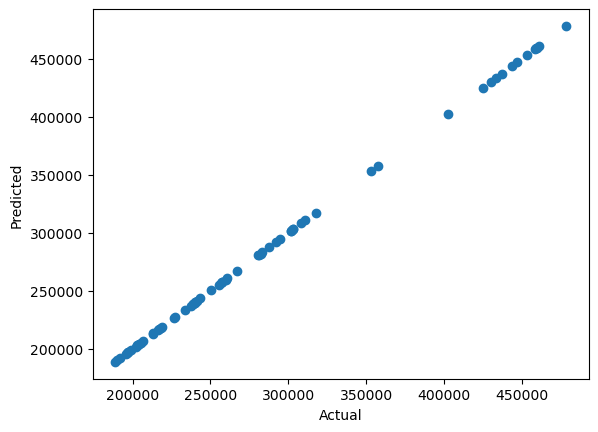

In [43]:
#plot predictions against acutal result
plt.scatter(y_test, test_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

The model has results perfectly fit to a regression line and the R-squared score shows overfitting

I'll use OLS to try to train the model better

In [46]:
#add constant for OLS
import statsmodels.api as sm
X_train_ols, X_test_ols = sm.add_constant(X_train), sm.add_constant(X_test)

In [47]:
#Peform OLS modeling and fitting
ols = sm.OLS(y_train, X_train_ols).fit()

In [48]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       mean_sales_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.814e+15
Date:                Wed, 11 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:49:08   Log-Likelihood:                 525.93
No. Observations:                 136   AIC:                            -1024.
Df Residuals:                     122   BIC:                            -983.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.629e+05      0.004    6.4e+07      0.000    2.63e+05    2.63e+05
pop_rank             -0.0069      0.027     -0.257      0.798      -0.060       0.046
number_of_sales    3.877e-05      0.001      0.036      0.971      -0.002       0.002
home_value         1.028e+05      0.002   5.91e+07      0.000    1.03e+05    1.03e+05
market_heat_index -1.568e-05   2.72e-05     -0.577      0.565   -6.95e-05    3.81e-05
value_surplus       2.55e+04      0.001   1.93e+07      0.000    2.55e+04    2.55e+04
col_0                -0.2035      2.293     -0.089      0.929      -4.743       4.336
col_1                 0.2666      1.743      0.153      0.879      -3.185       3.718
col_2                 0.0049      0.014      0.351      0.726      -0.023       0.033
col_3                 0.4672      1.767      0.264      0.792      -3.031       3.965
col_4                -0.0051      0.024     -0.215      0.830      -0.052       0.042
col_5                 0.8880      0.914      0.971      0.333      -0.922       2.698
col_6                -0.0008      0.006     -0.119      0.905      -0.013       0.012
state_0              -0.0002      0.005     -0.045      0.964      -0.010       0.010
state_1               0.0002      0.005      0.045      0.964      -0.010       0.010
==============================================================================
Omnibus:                        1.618   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.445   Jarque-Bera (JB):                1.232
Skew:                          -0.026   Prob(JB):                        0.540
Kurtosis:                       3.463   Cond. No.                     1.30e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.37e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

This model perfectly fits which seems to be a case of sever overfitting. We will have to regularize the data

Test on test data

In [51]:
ols_pred = ols.predict(X_test_ols)

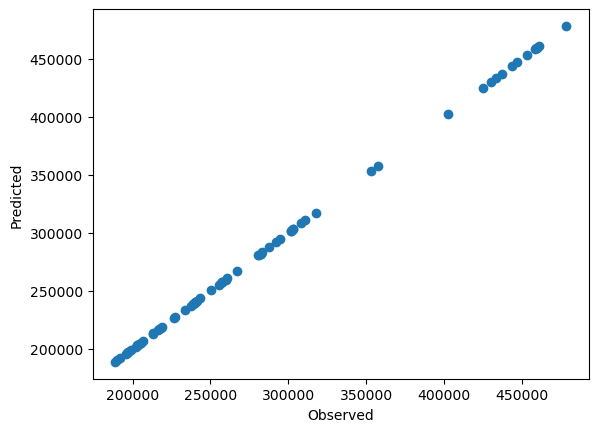

In [52]:
plt.scatter(y_test, ols_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

We'll use Ridge regression to try to regularize our data

In [54]:
from sklearn.linear_model import Ridge
#test ridge with mutliple alphas
alphas = [10.0, 30.0, 50.0, 75.0, 100.0, 1000.0]
scores = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    scores.append(ridge.score(X_test, y_test))

print(scores)

[0.9813780255624482, 0.9402480913825612, 0.9083328141025526, 0.8764525922956898, 0.8497290036093154, 0.43170077516739436]


We'll test on alpha of 65 as this provides a good R-squared coefficient but leaves enough room to avoid overfitting

In [56]:
ridge_model = Ridge(alpha=65)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

In [57]:
ridge_model.score(X_test, y_test)

0.8884166634592632

In [58]:
rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
print(rmse)

29061.07302326343


The root mean squared error is a little higher than we would have liked as prices range from about 250000 to 500000. Lets visualize the data

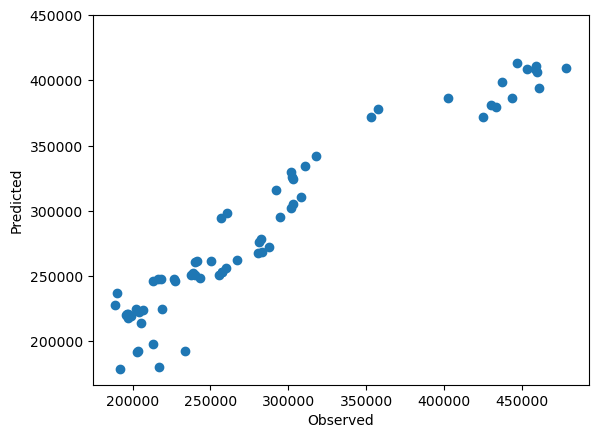

In [60]:
plt.scatter(y_test, ridge_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.yticks([200000, 250000, 300000, 350000, 400000, 450000])
plt.show()

In [61]:
#set prediction index to compare against test data
ridge_pred = pd.DataFrame(ridge_pred, index=y_test.index)
ridge_pred.head()

,0
date,
2008-04-01,294222.246008
2008-05-01,298068.065270
2008-08-01,192623.763671
2008-09-01,180561.181746
2008-11-01,191911.981987


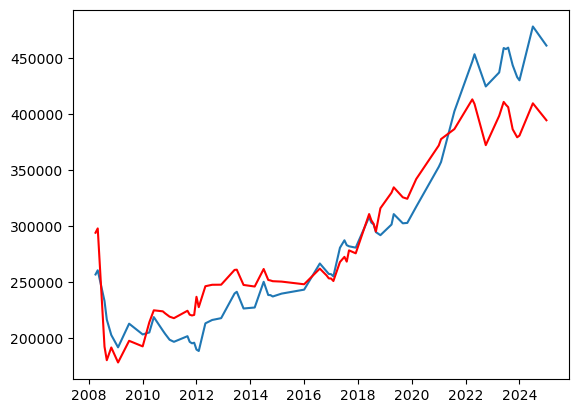

In [62]:
plt.plot(y_test)
plt.plot(ridge_pred, c='red')
plt.show()

Ridge is closely aligned but still gives a little more error than desired in some places. Overall a good result for a balance of generalization and accuracy. I'll try Lasso regression to see how it compares

In [64]:
from sklearn.linear_model import Lasso
alphas = [10000.0, 15000.0, 18000, 20000, 25000]
l_scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    l_scores.append(lasso.score(X_test, y_test))

print(l_scores)

[0.9691508220466544, 0.9305898965192813, 0.9000506838807342, 0.876604534332265, 0.8071950177944474]


We had to make the alpha values extremely high to have much affect. We'll try the model with 18000

In [66]:
lasso_model = Lasso(alpha=18000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

In [67]:
rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso_pred))
print(rmse_lasso)

38200.68055853647


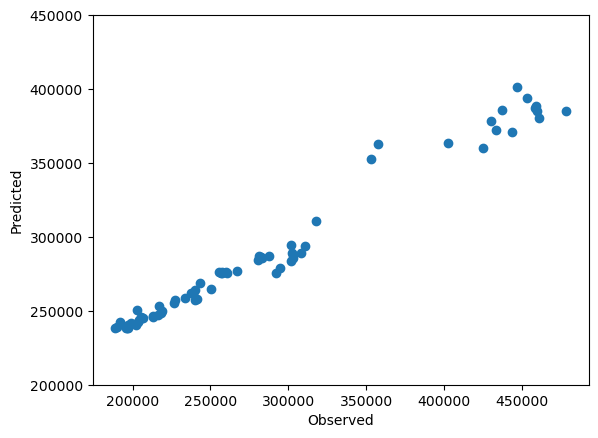

In [68]:
plt.scatter(y_test, lasso_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.yticks([200000, 250000, 300000, 350000, 400000, 450000])
plt.show()

This fit worse and had a much higher RMSE than Ridge regression so Ridge regression is the top option as of now

<h2>XGBoost</h2>

We'll try XGBoost to minimize RMSE

In [72]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [73]:
from xgboost import XGBRegressor
import xgboost as xg
#Convert to DMatrix objects
xg_model = XGBRegressor(reg_lambda=300,  learning_rate=0.12)
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.12, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [74]:
xg_pred = xg_model.predict(X_test)

In [75]:
xg_model.score(X_test, y_test)

0.8879654228625357

In [76]:
rmse_xg = np.sqrt(mean_squared_error(y_test, xg_pred))
print(rmse_xg)

29119.774910858137


In [77]:
print('Max: ', y_train.max(), y_test.max())
print('Min: ', y_train.min(), y_test.min())

Max:  488457.25 478127.2
Min:  192803.51 188783.25


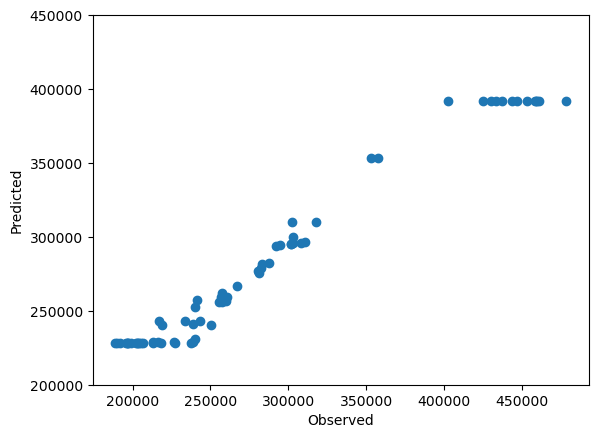

In [78]:
plt.scatter(y_test, xg_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.yticks([200000, 250000, 300000, 350000, 400000, 450000])
plt.show()

In [79]:
xg_pred = pd.DataFrame(xg_pred, index=y_test.index)
xg_pred.head()

,0
date,
2008-04-01,259295.328125
2008-05-01,259295.328125
2008-08-01,242866.468750
2008-09-01,242866.468750
2008-11-01,228266.296875


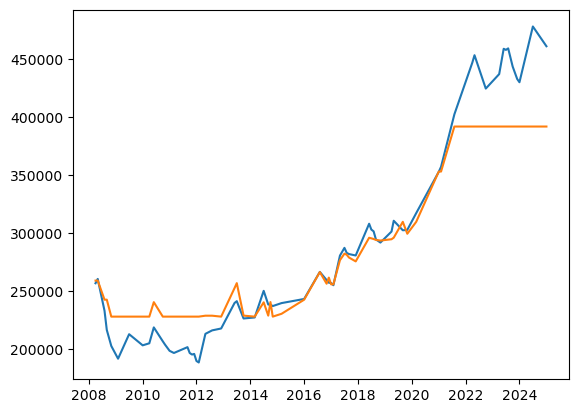

In [80]:
plt.plot(y_test)
plt.plot(xg_pred)
plt.show()

No matter what parameters are put in, the XG model either overfits or caps at certain values. Ridge regression still seems like the best option

<h2>ARIMA</h2>

<h3>Test for stationarity</h3>

In [84]:
#import modules
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [85]:
#kpss test for stationarity
from statsmodels.tsa.stattools import kpss
kpss_y = kpss(y_train)
print('p-value: ', kpss_y[1])

p-value:  0.01


/var/folders/95/yr6zk14d0rb52tgyfy426wwh0000gn/T/ipykernel_33629/1873126875.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_y = kpss(y_train)


In [86]:
#ADF test for stationarity
def adf_test(series, significance = 0.05):
    result = adfuller(series, autolag='AIC')
    output = pd.Series(result[0:4], index=['ADF Statistic', 'p-value', 'Lags', 'Observations'])
    for key, value in result[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    if result[1] < significance:
        print('time series is stationary')
    else:
        print('time series is non-stationary')

In [87]:
adf_test(y_train)

ADF Statistic             1.436264
p-value                   0.997273
Lags                      5.000000
Observations            130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64
time series is non-stationary


The tests confirm our training data is non-stationary so we will need to transform it

<Axes: xlabel='date'>

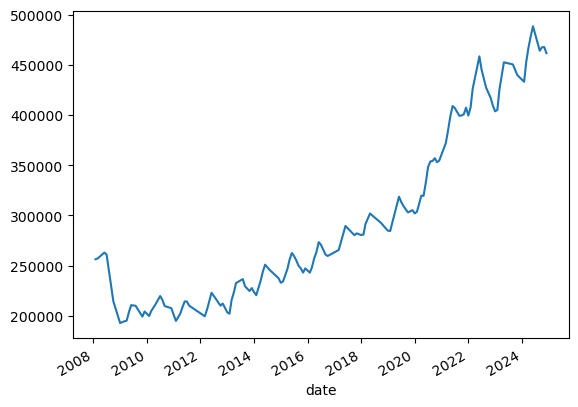

In [89]:
#view data
y_train.plot()

Take log of data to get constant variance

<Axes: xlabel='date'>

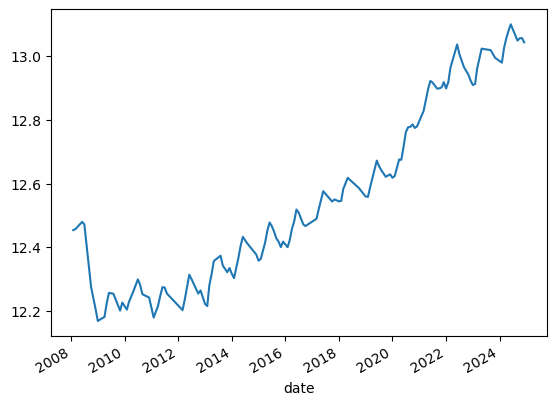

In [91]:
y_log = np.log(y_train)
y_log.plot()

To get constant mean, we'll difference the data 

In [93]:
y_diff = y_log.diff().dropna()
kpss_log = kpss(y_diff)
print('p-value: ', kpss_log[1])

p-value:  0.1


/var/folders/95/yr6zk14d0rb52tgyfy426wwh0000gn/T/ipykernel_33629/3015209065.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_log = kpss(y_diff)


In [94]:
adf_test(y_diff)

ADF Statistic          -8.092379e+00
p-value                 1.367296e-12
Lags                    4.000000e+00
Observations            1.300000e+02
Critical Value (1%)    -3.481682e+00
Critical Value (5%)    -2.884042e+00
Critical Value (10%)   -2.578770e+00
dtype: float64
time series is stationary


Now the data is confirmed by both tests to be stationary and we can model

<h3>Modeling</h3>

Function to find MSE

In [98]:
def mse_arima(data, arima_order):
    #change dtype to int to use as index later
    split = int(len(data) * 0.8)
    #Create train/test variables
    train, test = data[0:split], data[split:len(data)]
    past= [x for x in train]
    #predictions
    predictions = list()
    #comparison between test data & one-stop prediction ARIMA model
    for i in range(len(test)):
        model=ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future= model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    #Calculate sample error
    error = mean_squared_error(test, predictions)
    return error

Function to evaluate ARIMA model order

In [100]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score = float('inf')
    best_cfg = None
    #iterate through p, then d, then q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                #see if mse if less than best score
                try:
                    mse = mse_arima(dataset, order)
                    if mse < best_score:
                        best_score = mse 
                        best_cfg = order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA:', best_cfg, ' MSE:', best_score)

In [101]:
#set p, d, q values to test
p_values = [0, 1, 2]
d_values = [0, 1, 2]
q_values = [0, 1, 2]

In [102]:
import warnings
warnings.filterwarnings("ignore")
#find optimum ARIMA order
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.238
ARIMA(0, 0, 1) MSE=0.064
ARIMA(0, 0, 2) MSE=0.022
ARIMA(0, 1, 0) MSE=0.001
ARIMA(0, 1, 1) MSE=0.001
ARIMA(0, 1, 2) MSE=0.001
ARIMA(0, 2, 0) MSE=0.001
ARIMA(0, 2, 1) MSE=0.001
ARIMA(0, 2, 2) MSE=0.001
ARIMA(1, 0, 0) MSE=0.001
ARIMA(1, 0, 1) MSE=0.001
ARIMA(1, 0, 2) MSE=0.001
ARIMA(1, 1, 0) MSE=0.001
ARIMA(1, 1, 1) MSE=0.001
ARIMA(1, 1, 2) MSE=0.001
ARIMA(1, 2, 0) MSE=0.001
ARIMA(1, 2, 1) MSE=0.001
ARIMA(1, 2, 2) MSE=0.001
ARIMA(2, 0, 0) MSE=0.001
ARIMA(2, 0, 1) MSE=0.001
ARIMA(2, 0, 2) MSE=0.001
ARIMA(2, 1, 0) MSE=0.001
ARIMA(2, 1, 1) MSE=0.001
ARIMA(2, 1, 2) MSE=0.001
ARIMA(2, 2, 0) MSE=0.001
ARIMA(2, 2, 1) MSE=0.001
ARIMA(2, 2, 2) MSE=0.001
Best ARIMA: (2, 1, 1)  MSE: 0.0006747164799735028


The best p,d,q values are 2,1,1 so we'll fit an ARIMAX model with that and bring in our X data

In [104]:
a_model = ARIMA(y_log, exog=X_train, order=(2,1,1))
arima_fit = a_model.fit()

In [105]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       mean_sales_price   No. Observations:                  136
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 475.001
Date:                Wed, 11 Jun 2025   AIC                           -914.003
Time:                        19:51:47   BIC                           -861.708
Sample:                             0   HQIC                          -892.751
                                - 136                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
pop_rank              0.0073      0.057      0.128      0.898      -0.104       0.119
number_of_sales       0.0071      0.002      2.836      0.005       0.002       0.012
home_value            0.2835      0.021     13.262      0.000       0.242       0.325
market_heat_index     0.0001   8.79e-05      1.534      0.125   -3.74e-05       0.000
value_surplus         0.0770      0.002     32.027      0.000       0.072       0.082
col_0                 0.1505      5.252      0.029      0.977     -10.144      10.445
col_1                 0.2885      3.308      0.087      0.931      -6.196       6.773
col_2                 0.0246      0.037      0.668      0.504      -0.048       0.097
col_3                 0.0597      4.338      0.014      0.989      -8.443       8.562
col_4                 0.0177      0.055      0.322      0.748      -0.090       0.126
col_5                 2.0442      1.983      1.031      0.303      -1.843       5.932
col_6                 0.0090      0.013      0.685      0.493      -0.017       0.035
state_0               0.0011      0.011      0.101      0.919      -0.020       0.022
state_1              -0.0016      0.011     -0.149      0.881      -0.023       0.020
ar.L1                 0.8872      0.197      4.496      0.000       0.500       1.274
ar.L2                -0.4189      0.111     -3.787      0.000      -0.636      -0.202
ma.L1                -0.5404      0.225     -2.404      0.016      -0.981      -0.100
sigma2             5.121e-05   6.43e-06      7.965      0.000    3.86e-05    6.38e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):                 3.57
Prob(Q):                              0.32   Prob(JB):                         0.17
Heteroskedasticity (H):               0.74   Skew:                            -0.04
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.41e+22. Standard errors may be unstable.
"""

Very low AIC and BIC means the model is strong but it may be overfit. 

In [107]:
forecast_log = arima_fit.predict()
forecast_log

date
2008-02-01    -0.022394
2008-03-01    12.458994
2008-06-01    12.479747
2008-07-01    12.475009
2008-10-01    12.285461
                ...    
2024-08-01    13.050268
2024-09-01    13.047314
2024-10-01    13.060637
2024-11-01    13.048898
2024-12-01    13.038307
Name: predicted_mean, Length: 136, dtype: float64

In [108]:
#transforming log data back to exponents to compare against our test data
forecast_actual = np.exp(forecast_log)
forecast_actual

date
2008-02-01         0.977854
2008-03-01    257556.490708
2008-06-01    262957.346061
2008-07-01    261714.306999
2008-10-01    216524.856506
                  ...      
2024-08-01    465220.961374
2024-09-01    463848.772612
2024-10-01    470070.179745
2024-11-01    464584.279229
2024-12-01    459689.612956
Name: predicted_mean, Length: 136, dtype: float64

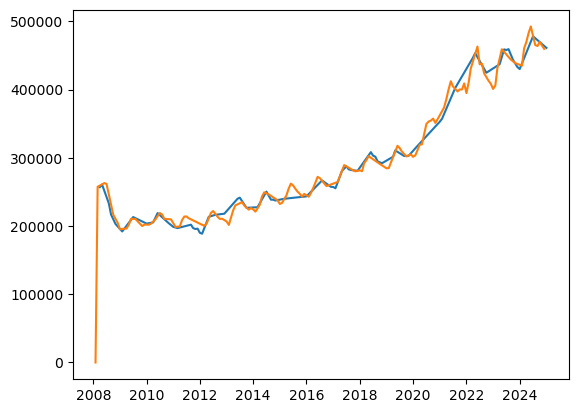

In [109]:
plt.plot(y_test)
plt.plot(forecast_actual)
plt.show()

This also looks overfit. The best option for modeling will be Ridge Regression

<h1>Forecasting</h1>

In [112]:
pip install skforecast

Note: you may need to restart the kernel to use updated packages.


In [113]:
#train forecaster model with Ridge Regression
from skforecast.recursive import ForecasterRecursive
forecaster = ForecasterRecursive(regressor=ridge_model,
                                lags=24)
forecaster.fit(y)

In [114]:
#predictions
steps = 60 #predicting 5 years of data
predictions = forecaster.predict(steps=steps).round(2)
predictions.head()

24    465261.67
25    481470.46
26    497015.21
27    508123.49
28    515046.17
Name: pred, dtype: float64

In [115]:
#create index for predictions
future_dates = pd.date_range(start='2025-02-01', end='2030-02-01', freq='ME')
predictions = pd.DataFrame(predictions)
predictions = predictions.set_index(future_dates)
predictions.head()

,pred
2025-02-28,465261.67
2025-03-31,481470.46
2025-04-30,497015.21
2025-05-31,508123.49
2025-06-30,515046.17


<h2>US Forecasting</h2>

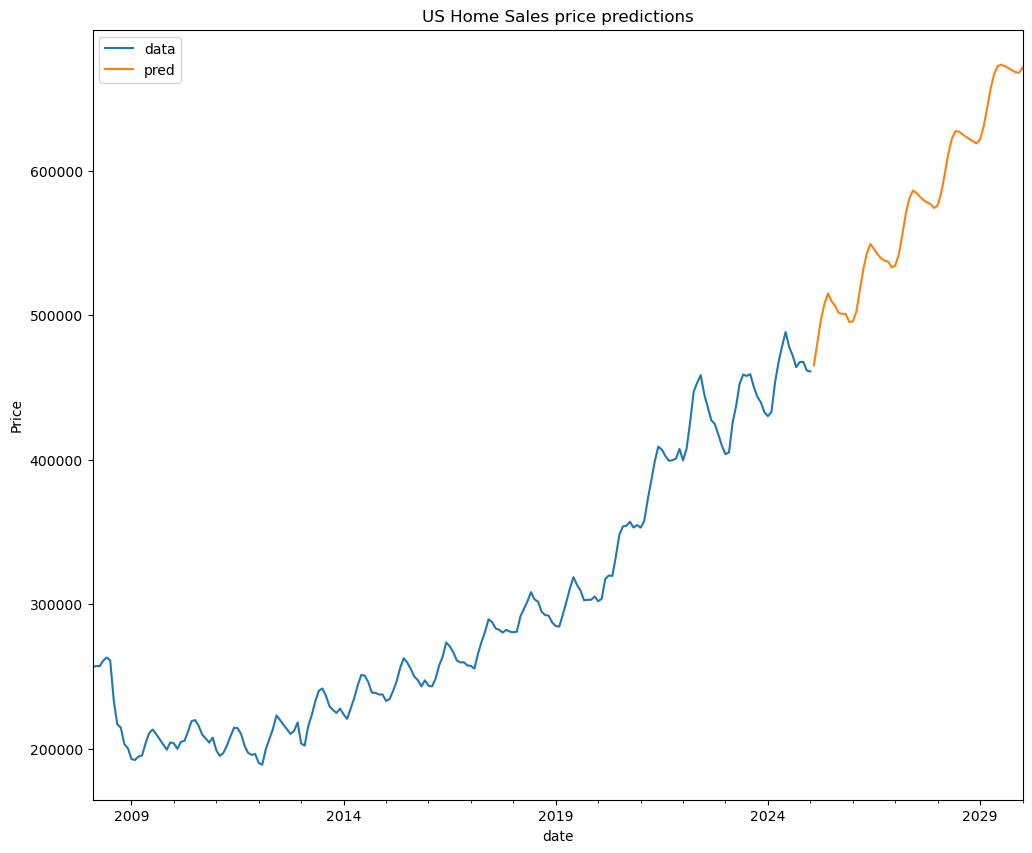

In [117]:
#plot predictions
fig, ax = plt.subplots(figsize=(12, 10))
y.plot(ax=ax, label='data')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.ylabel('Price')
plt.title('US Home Sales price predictions')
plt.show()

In [118]:
last_prediction = predictions.iloc[-1, 0].round(2)
print('The average US home price in 2030 will be', last_prediction, 'USD.')
print('This is a 5 year increase of', (last_prediction - encoded_df['mean_sales_price'].iloc[-1]).round(2), 'USD.')

The average US home price in 2030 will be 671450.46 USD.
This is a 5 year increase of 210342.0 USD.


<h2>State Forecasting</h2>

Now we will break down the data for each state and compare

First, separate the original data into states

In [122]:
state_data = data.drop(columns='city')
group_by_state = state_data.groupby(['state', 'date']).median().round(2)
group_by_state = group_by_state.reset_index('date')
group_by_state.head()

,date,pop_rank,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus
state,,,,,,,
AL,2008-02-01,135.0,315109.38,1538.5,148049.87,50.0,175179.60
AL,2008-03-01,135.0,299880.90,1538.5,147589.04,50.0,160086.60
AL,2008-04-01,135.0,298647.75,1538.5,147347.01,50.0,156110.89
AL,2008-05-01,135.0,309736.10,1538.5,147216.82,50.0,168144.16
AL,2008-06-01,135.0,300829.25,1538.5,147159.07,50.0,161692.09


Now we will create a dictionary for the dfs of each state

In [124]:
uniqueState = list(state_data.state.unique())

In [125]:
#separate into dfs within dict
state_dfs = {}
for state in uniqueState:
    state_dfs[state] = group_by_state[group_by_state.index == state].copy()

Now with the states separated into individual dataframes, we can use our model to forecast on each state.

In [127]:
#predict on each state
future_home_prices = {}
for state in state_dfs:
    indexed_df = state_dfs[state].reset_index().set_index('date')
    y = indexed_df['mean_sales_price']
    forecaster = ForecasterRecursive(ridge_model, lags=24)
    forecaster.fit(y)
    predictions = forecaster.predict(steps=steps).round(2)
    predictions = pd.DataFrame(predictions)
    predictions = predictions.set_index(future_dates)
    future_home_prices[state] = predictions.iloc[-1, 0].round(2)

In [128]:
future_home_prices = dict(sorted(future_home_prices.items(), key=lambda item: item[1], reverse=True))
future_home_prices

{'HI': 1160246.05,
 'RI': 1157088.46,
 'NV': 1121203.83,
 'ME': 1042779.41,
 'MA': 1034306.53,
 'WA': 1005279.72,
 'OR': 874490.21,
 'DE': 871454.22,
 'CT': 841853.29,
 'CA': 823924.79,
 'CO': 793746.71,
 'UT': 782052.22,
 'ID': 699297.64,
 'VA': 698320.23,
 'AZ': 693049.83,
 'NC': 667096.0,
 'TN': 661314.9,
 'WI': 658612.78,
 'NM': 629054.95,
 'SC': 628186.95,
 'GA': 612503.03,
 'FL': 609109.05,
 'KY': 603718.58,
 'NE': 590175.9,
 'AR': 589464.86,
 'MN': 585174.51,
 'PA': 576684.58,
 'MS': 521244.64,
 'MD': 488330.64,
 'IA': 481995.21,
 'IL': 455899.8,
 'IN': 443376.27,
 'NY': 442152.39,
 'OK': 436842.48,
 'MI': 367622.04,
 'MO': 358464.85,
 'TX': 354175.4,
 'KS': 349759.01,
 'LA': 316758.79,
 'OH': 275177.31,
 'AL': 222873.83}

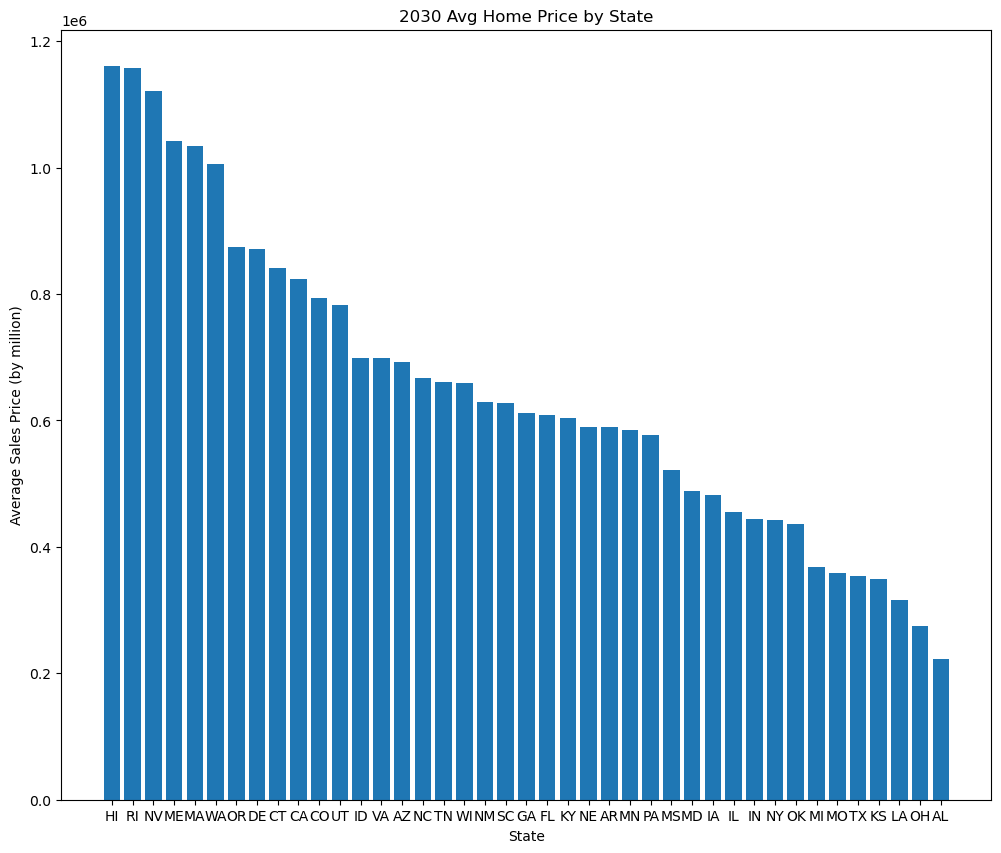

In [129]:
#plot data
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(future_home_prices.keys(), future_home_prices.values())
plt.xlabel('State')
plt.ylabel('Average Sales Price (by million)')
plt.title('2030 Avg Home Price by State')
plt.show()

Our model results in Hawaii having the highest average home price in 2030 at 1,160,246 USD with Rhode Island and Nevada slightly behind at 1,157,088 USD and 1,121,203 USD respectively

We can now observe the change over five years for each state

In [132]:
#pull current prices from each state
state_current_price = {}
for state in state_dfs:
    last_row = state_dfs[state].iloc[-1]
    last_price = last_row['mean_sales_price']
    state_current_price[state] = last_price

In [133]:
#create df with both data
state_roi = pd.DataFrame([future_home_prices, state_current_price])
state_roi = state_roi.T
state_roi.rename(columns={0: 'price_2030', 1: 'price_2025'}, inplace=True)
state_roi.head()

,price_2030,price_2025
HI,1160246.05,1123507.0
RI,1157088.46,646531.0
NV,1121203.83,719671.5
ME,1042779.41,546471.0
MA,1034306.53,639651.0


In [134]:
#create roi columns
state_roi['ROI'] = state_roi['price_2030'] - state_roi['price_2025']
state_roi['ROI_percent'] = (((state_roi['price_2030'] - state_roi['price_2025']) / state_roi['price_2025']) * 100).round(2)
state_roi = state_roi.sort_values(by='ROI_percent', ascending=False)
state_roi

,price_2030,price_2025,ROI,ROI_percent
IL,455899.80,223226.0,232673.80,104.23
CT,841853.29,439482.0,402371.29,91.56
ME,1042779.41,546471.0,496308.41,90.82
PA,576684.58,302808.5,273876.08,90.45
TN,661314.90,365099.0,296215.90,81.13
RI,1157088.46,646531.0,510557.46,78.97
VA,698320.23,396208.0,302112.23,76.25
NC,667096.00,382510.0,284586.00,74.40
NE,590175.90,339921.0,250254.90,73.62
KY,603718.58,348635.0,255083.58,73.17


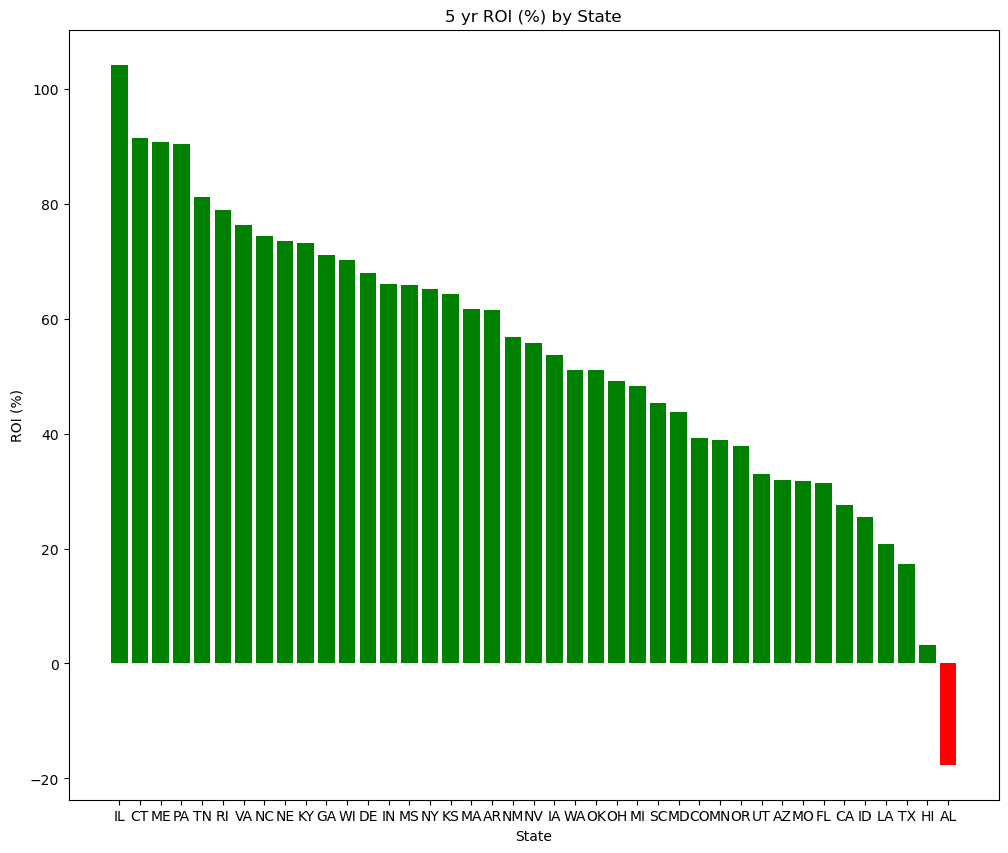

In [135]:
#assign color with value for better visualization
def color_chart(column):
    """Assign green for positive values and red for negative"""
    return ['green' if i >=0 else 'red' for i in column]

#plot data
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(state_roi.index, state_roi.ROI_percent, color=color_chart(state_roi['ROI_percent']))
plt.xlabel('State')
plt.ylabel('ROI (%)')
plt.title('5 yr ROI (%) by State')
plt.show()

We can see that Illinois has the highest ROI percentage over 5 years with 104% ROI. Connecticut, Maine, and Pennsylvania also had over 90% ROI in the next 5 years.

Now we'll examine the total ROI for each state

In [138]:
state_roi = state_roi.sort_values('ROI', ascending=False)
state_roi

,price_2030,price_2025,ROI,ROI_percent
RI,1157088.46,646531.0,510557.46,78.97
ME,1042779.41,546471.0,496308.41,90.82
CT,841853.29,439482.0,402371.29,91.56
NV,1121203.83,719671.5,401532.33,55.79
MA,1034306.53,639651.0,394655.53,61.70
DE,871454.22,518715.0,352739.22,68.00
WA,1005279.72,665142.5,340137.22,51.14
VA,698320.23,396208.0,302112.23,76.25
TN,661314.90,365099.0,296215.90,81.13
NC,667096.00,382510.0,284586.00,74.40


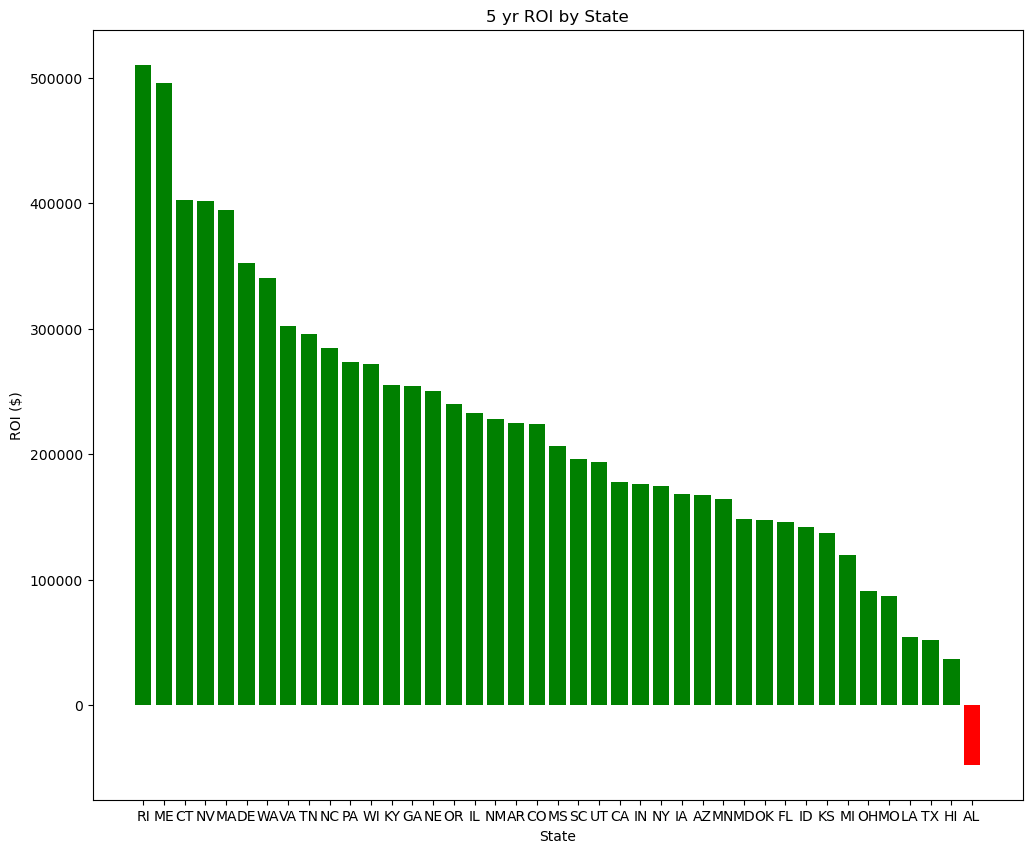

In [139]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(state_roi.index, state_roi.ROI, color=color_chart(state_roi['ROI']))
plt.xlabel('State')
plt.ylabel('ROI ($)')
plt.title('5 yr ROI by State')
plt.show()

Here, Rhode Island leads in the total ROI over 5 years with a total ROI of 510,557 USD which is a 79% increase. Maine was not far behind with an increase of 496308 USD and as we mentioned previously, it had over a 90% increase.

<h2>City Forecasting</h2>

Now, we'll do the same breakdown for cities from our data

In [143]:
city_data = data.drop(columns='state')
group_by_city = city_data.groupby(['city', 'date']).median().round(2)
group_by_city = group_by_city.reset_index('date')
group_by_city.head()

,date,pop_rank,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus
city,,,,,,,
"Akron, OH",2008-02-01,83.0,111182.75,398.0,124307.87,61.0,-13125.12
"Akron, OH",2008-03-01,83.0,117496.40,403.0,124112.73,61.0,-6616.33
"Akron, OH",2008-04-01,83.0,116325.50,480.0,124067.90,61.0,-7742.40
"Akron, OH",2008-05-01,83.0,140846.00,478.0,124246.82,61.0,16599.18
"Akron, OH",2008-06-01,83.0,137244.50,603.0,124224.50,61.0,13020.00


In [144]:
unique_city = list(city_data.city.unique())

In [145]:
city_dfs = {}
for city in unique_city:
    city_dfs[city] = group_by_city[group_by_city.index == city].copy()

In [146]:
city_future_prices = {}
for city in city_dfs:
    indexed_df = city_dfs[city].reset_index().set_index('date')
    y = indexed_df['mean_sales_price']
    forecaster = ForecasterRecursive(ridge_model, lags=24)
    forecaster.fit(y)
    predictions = forecaster.predict(steps=steps).round(2)
    predictions = pd.DataFrame(predictions)
    predictions = predictions.set_index(future_dates)
    city_future_prices[city] = predictions.iloc[-1, 0].round(2)

In [147]:
city_prices = dict(sorted(city_future_prices.items(), key=lambda item: item[1], reverse=True))

In [148]:
future_city_df = pd.DataFrame.from_dict(city_prices, orient='index', columns=['price_2030'])
future_city_df = future_city_df.reset_index()
future_city_df.rename(columns={'index': 'city'}, inplace=True)
future_city_df.head()

,city,price_2030
0,"San Jose, CA",2713933.86
1,"Barnstable Town, MA",1867100.44
2,"Los Angeles, CA",1578702.95
3,"San Francisco, CA",1544387.43
4,"San Diego, CA",1520943.27


In [152]:
#bring in state data
city_state = data[['city', 'state']]
city_state_future = future_city_df.merge(city_state, how='left', on='city')
city_state_future = city_state_future.drop_duplicates(keep='first').reset_index()

In [154]:
#create list of top 25 Cities
city_top25 = city_state_future.drop(columns='index').head(25)
city_top25

,city,price_2030,state
0,"San Jose, CA",2713933.86,CA
1,"Barnstable Town, MA",1867100.44,MA
2,"Los Angeles, CA",1578702.95,CA
3,"San Francisco, CA",1544387.43,CA
4,"San Diego, CA",1520943.27,CA
5,"New York, NY",1358661.52,NY
6,"Reno, NV",1343577.49,NV
7,"Oxnard, CA",1338210.49,CA
8,"Naples, FL",1321114.24,FL
9,"Boston, MA",1313346.86,MA


In [156]:
city_top25.value_counts('state')

state
CA    7
FL    3
MA    2
AZ    1
CT    1
HI    1
ME    1
NC    1
NV    1
NY    1
RI    1
SC    1
TN    1
UT    1
VA    1
WA    1
Name: count, dtype: int64

California leads the way with 7 cities in the top 25 home prices in 2030

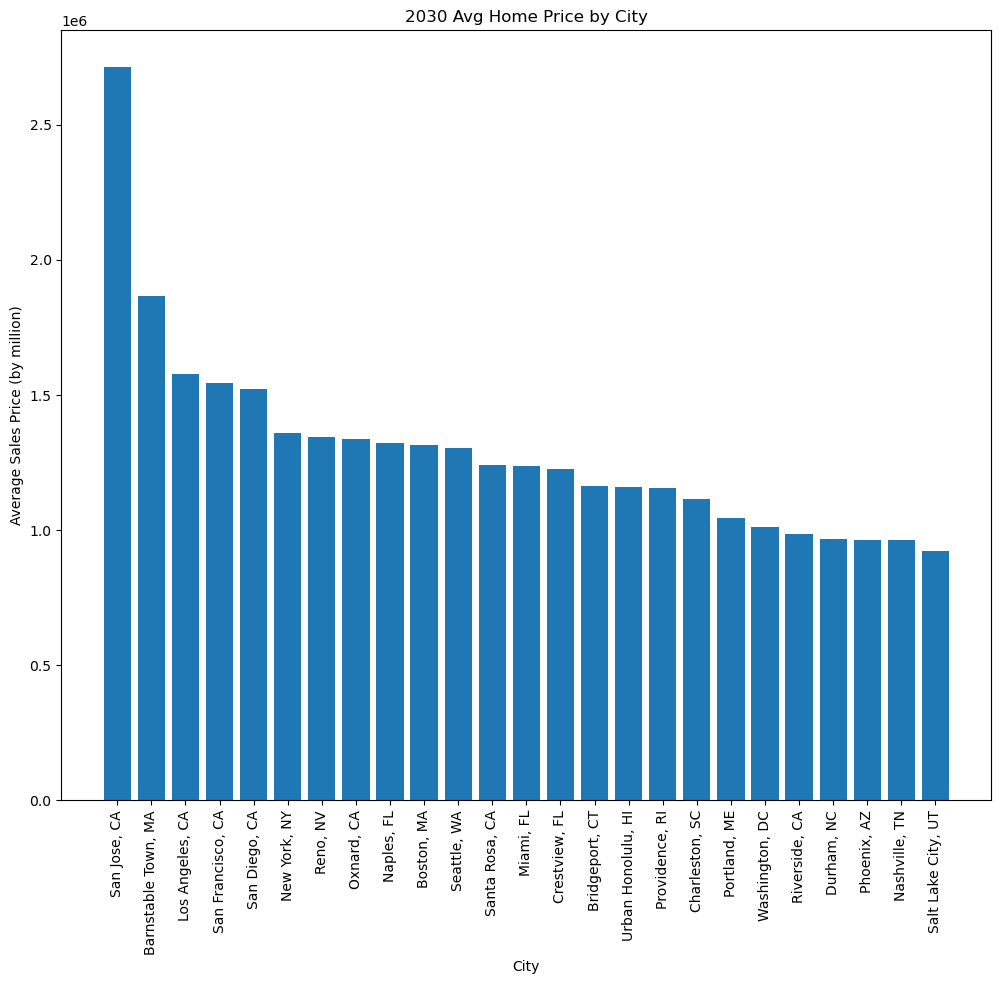

In [158]:
#plot data
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(city_top25['city'], city_top25['price_2030'])
plt.xlabel('City')
plt.ylabel('Average Sales Price (by million)')
plt.xticks(rotation=90)
plt.title('2030 Avg Home Price by City')
plt.show()

We can see that San Jose (CA) will have by far the highest home price in 2030 at 2,713,933 USD. All other cities are under 2M USD.

Now well observe the 5 year ROI as we did for states

In [160]:
city_current_price = {}
for city in city_dfs:
    last_row = city_dfs[city].iloc[-1]
    last_price = last_row['mean_sales_price']
    city_current_price[city] = last_price

city_current_price = pd.DataFrame.from_dict(city_current_price, orient='index', columns=['price_2025'])
city_current_price = city_current_price.reset_index()
city_current_price = city_current_price.rename(columns={'index': 'city'})

In [162]:
#create df with both data
city_roi = city_state_future.merge(city_current_price, how='left', on='city')

city_roi.head()

,index,city,price_2030,state,price_2025
0,0,"San Jose, CA",2713933.86,CA,1949899.0
1,204,"Barnstable Town, MA",1867100.44,MA,1078110.0
2,402,"Los Angeles, CA",1578702.95,CA,1228981.0
3,606,"San Francisco, CA",1544387.43,CA,1286942.0
4,810,"San Diego, CA",1520943.27,CA,1100177.0


In [164]:
#drop index, create roi columns
city_roi = city_roi.drop(columns='index')
city_roi['ROI'] = city_roi['price_2030'] - city_roi['price_2025']
city_roi['ROI_percent'] = (((city_roi['price_2030'] - city_roi['price_2025']) / city_roi['price_2025']) * 100).round(2)

In [166]:
#reorder columns and identify top 25 roi
new_order = ['city', 'state', 'price_2030', 'price_2025', 'ROI_percent', 'ROI']
city_roi = city_roi.reindex(columns=new_order)
city_roi_25 = city_roi.sort_values('ROI_percent', ascending=False).head(25)
city_roi_25

,city,state,price_2030,price_2025,ROI_percent,ROI
64,"Reading, PA",PA,610408.25,298995.0,104.15,311413.25
62,"Harrisburg, PA",PA,613155.23,303263.0,102.19,309892.23
21,"Durham, NC",NC,966501.74,485795.0,98.95,480706.74
31,"New Haven, CT",CT,860949.11,439482.0,95.90,421467.11
35,"Hartford, CT",CT,794113.58,405942.0,95.62,388171.58
84,"Rochester, NY",NY,518103.19,267530.0,93.66,250573.19
29,"Savannah, GA",GA,868717.22,453105.0,91.73,415612.22
18,"Portland, ME",ME,1042779.41,546471.0,90.82,496308.41
77,"Columbia, SC",SC,544515.80,289841.0,87.87,254674.80
42,"Lexington, KY",KY,730573.87,396138.0,84.42,334435.87


In [168]:
city_roi_25.value_counts('state')

state
NC    4
NY    4
PA    4
GA    2
CT    2
SC    2
ME    1
IN    1
KY    1
OH    1
RI    1
TN    1
VA    1
Name: count, dtype: int64

ROI percentage is more widespread among states in the top 25. North Carolina, New York, and Pennsylvania all have 4 cities in the top 25 ROI %.

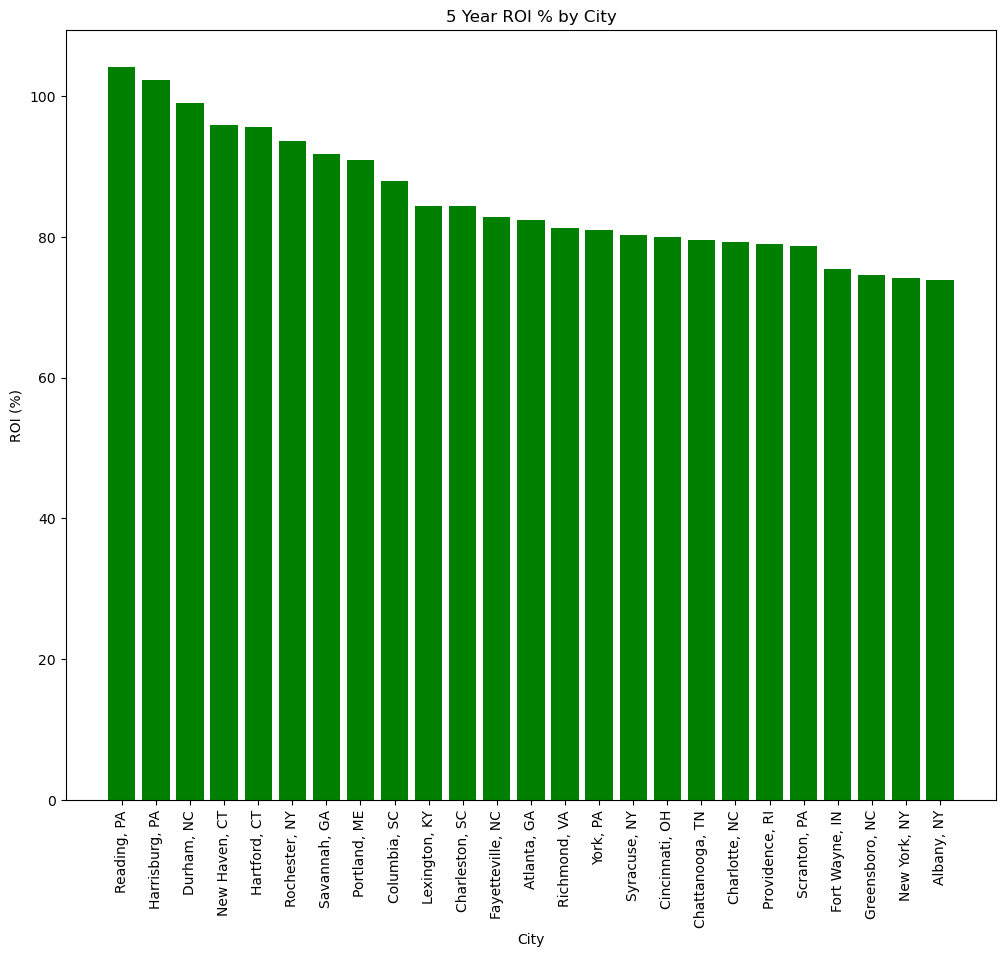

In [170]:
#plot data
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(city_roi_25['city'], city_roi_25['ROI_percent'], color=color_chart(city_roi_25['ROI_percent']))
plt.xlabel('City')
plt.ylabel('ROI (%)')
plt.xticks(rotation=90)
plt.title('5 Year ROI % by City')
plt.show()

Hear we can see that Reading (PA) and Harrisburg (PA) lead in ROI % at 104% and 102% respectively. 

In [172]:
#raw ROI by city
city_roi_25 = city_roi.sort_values('ROI', ascending=False).head(25)
city_roi_25

,city,state,price_2030,price_2025,ROI_percent,ROI
1,"Barnstable Town, MA",MA,1867100.44,1078110.0,73.18,788990.44
0,"San Jose, CA",CA,2713933.86,1949899.0,39.18,764034.86
5,"New York, NY",NY,1358661.52,780305.0,74.12,578356.52
16,"Providence, RI",RI,1157088.46,646531.0,78.97,510557.46
17,"Charleston, SC",SC,1114231.78,604560.0,84.30,509671.78
18,"Portland, ME",ME,1042779.41,546471.0,90.82,496308.41
21,"Durham, NC",NC,966501.74,485795.0,98.95,480706.74
9,"Boston, MA",MA,1313346.86,848719.0,54.74,464627.86
12,"Miami, FL",FL,1238169.38,792444.0,56.25,445725.38
10,"Seattle, WA",WA,1305000.42,871841.0,49.68,433159.42


In [174]:
city_roi_25.value_counts('state')

state
CA    3
NC    3
VA    2
MA    2
CT    2
GA    2
AZ    1
FL    1
DE    1
ME    1
KY    1
NY    1
NV    1
RI    1
SC    1
TN    1
WA    1
Name: count, dtype: int64

When we go by ROI value, California and North Carolina lead with 3 cities

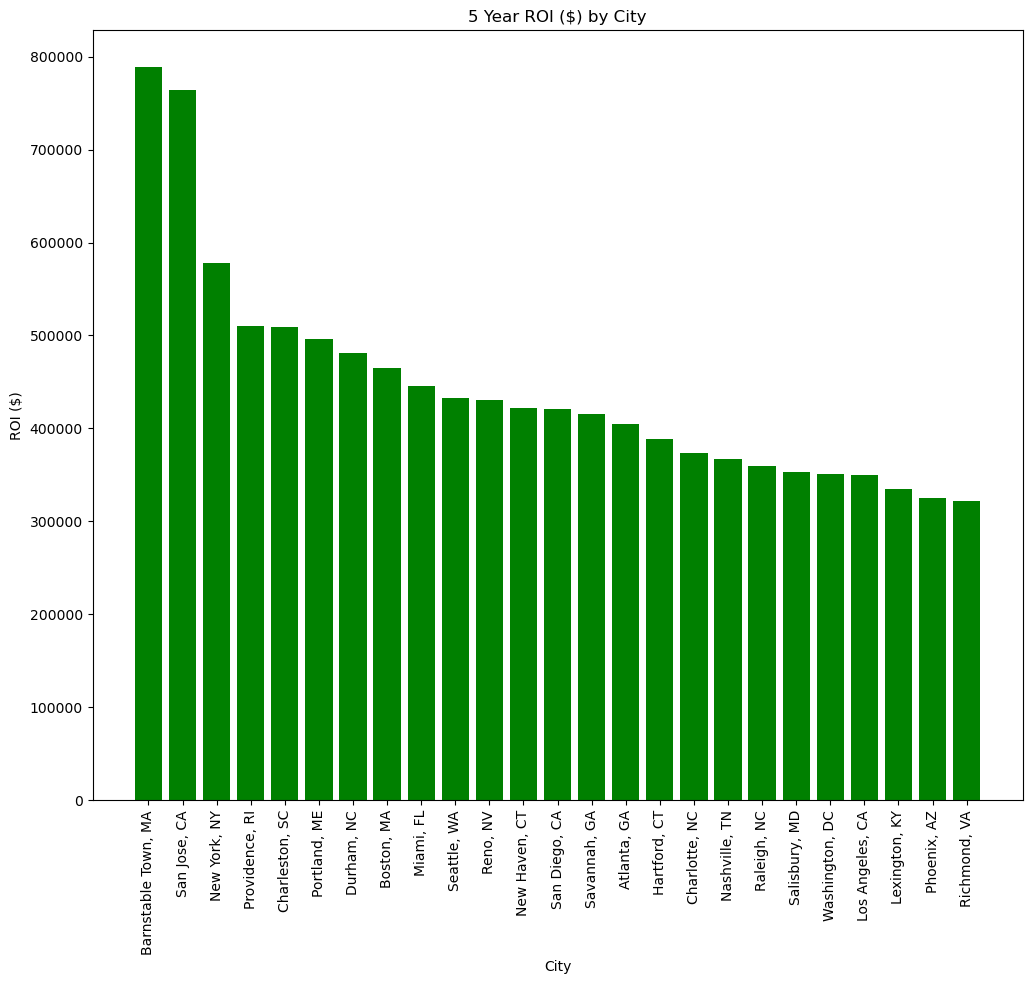

In [178]:
#plot raw ROI
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(city_roi_25['city'], city_roi_25['ROI'], color=color_chart(city_roi_25['ROI']))
plt.xlabel('City')
plt.ylabel('ROI ($)')
plt.xticks(rotation=90)
plt.title('5 Year ROI ($) by City')
plt.show()

The largest 5 year ROI increase will be Barnstable Town (MA) with an increase of 788,990 USD followed closely by San Jose (CA) which increases by 764,034 USD.